# ONNX to TF-Lite Model Conversion

This tutorial describes how to convert an [ONNX](https://onnx.ai/) formatted model file into a format that can execute on an embedded device using [Tensorflow-Lite Micro](https://github.com/tensorflow/tflite-micro).

## Quick Links

- [GitHub Source](https://github.com/SiliconLabs/mltk/blob/master/mltk/tutorials/onnx_to_tflite.ipynb) - View this tutorial on Github
- [Run on Colab](https://colab.research.google.com/github/siliconlabs/mltk/blob/master/mltk/tutorials/onnx_to_tflite.ipynb) - Run this tutorial on Google Colab

## Overview 

[ONNX](https://onnx.ai/) is an open data format built to represent machine learning models. Many machine learning frameworks allow for exporting their trained models to this format.  
Using the process defined in this tutorial, a machine learning model in the [ONNX](https://onnx.ai/) can be converted to a int8 quantized [Tensorflow-Lite](https://www.tensorflow.org/lite/convert) format which can be executed on an embedded device.


The basic sequence for this is shown in the following diagram:  
![onnx_to_tflite](https://www.silabs.com/public/files/github/mltk/misc/onnx_to_tflite.png)

Once the `.tflite` model is generated, the MLTK's [Model Profiler](https://siliconlabs.github.io/mltk/docs/guides/model_profiler.html) is used to profile the model to ensure it can efficiently run on an embedded target.


### About this Tutorial
This tutorial describes how to take a model trained by [Matlab](https://www.mathworks.com/products/matlab.html) and run it on an embedded device with [Tensorflow-Lite Micro](https://github.com/tensorflow/tflite-micro).

The model is a simple CNN and uses the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

The Matlab model training scripts and trained model may be downloaded from here: [cifar10_matlab_model.zip](https://www.dropbox.com/s/8m72rmxtznvaki6/cifar10_matlab_model.zip?dl=1).

__NOTE:__ While the Matlab scripts are provided as a reference, they are out-of-scope for this tutorial.  
The key part of the script is the line:

```
exportONNXNetwork(trainedNet,'cifar10_matlab_model.onnx')
```

Which converts the trained Matlab model to the [ONNX](https://onnx.ai/) data format. The rest of this tutorial describes how to generate a quantized `.tflite` model file from it.  
Other ML frameworks should follow a similar process.

## Considerations

Unfortunately, converting from another framework into the [Tensorflow-Lite](https://www.tensorflow.org/lite/convert) format is not straight-forward. You must be mindful of several aspects when doing the conversion:

### Input Data Format

Any preprocessing that is done to the input samples during training _must_ also be done at runtime on the embedded device.  
So, for instance, if your training scripts scale the input image by 255 then the images must also be scaled on the embedded device.  
Any divergence will cause the ML model to "see" different data and likely reduce accuracy.


### Output Class ID Mapping

If the ML model is a classifier, then each class label has a corresponding ID associated with it.  
For instance:  

| Class Label | ID |
|-------------|----|
| Left        | 0  |
| Right       | 1  |
| Up          | 2  |
| Down        | 3  |

When the model makes a prediction, it returns a probability vector with the index of the largest vector entry mapping to the corresponding predicted class ID.  
The mapping used by training _must_ match the mapping used at runtime by the embedded device.

Do not make assumptions about the ID mapping used during training. Frameworks like Matlab use categorical arrays where the entries are not necessarily ordered.


### Supported ML Kernel Operations

The operations used by your ML model _must_ also be supported by [Tensorflow-Lite Micro](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/kernels).  

### "Channels-First" vs "Channels-Last"

Most frameworks define their kernel tensors to have the following dimensions:

- __N__ - Number of mini-batch samples in the tensor
- __H__ - The height of the tensor
- __W__ - The width of the tensor
- __C__ - The number of channels (aka depth) of the tensor

The most common dimension ordering is:
- __Channels-First__: __NCHW__ - The channels come before the height and width dimensions
- __Channels-Last__: __NHWC__ - The channels come after the height and width dimensions


Tensorflow-Lite Micro only supports Channels-Last while the ONNX format requires Channels-First.  
Converting from one format to the other is non-trivial. This tutorial describes how to do the conversion.


### Dataset Required for Quantization

The dataset used to train the model is also required to generate a quantized model. 
Recall that the quantized model is what is loaded onto the embedded device.

Refer to the [Post Training Quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) guide for more details.


## Running this tutorial from a notebook

For documentation purposes, this tutorial was designed to run within a [Jupyter Notebook](https://jupyter.org). 
The notebook can either run locally on your PC _or_ on a remote server like [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb).  

- Refer to the [Notebook Examples Guide](https://siliconlabs.github.io/mltk/docs/guides/notebook_examples_guide.html) for more details
- Click here: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/siliconlabs/mltk/blob/master/mltk/tutorials/onnx_to_tflite.ipynb) to run this tutorial interactively in your browser

## Environment Setup

Before converting the `.onnx` formatted model to a `.tflite` formatted model file, we need to setup our Python environment:

### Install Python Dependencies

Before running the various code snippets in this tutorial, several Python dependencies must first be installed:

In [ ]:
# Install the MLTK (if necessary)
!pip install --upgrade silabs-mltk

In [ ]:
# Install the standard ONNX Python package
# so that we can read the .onnx formatted model file
!pip install onnx onnx_tf

In [ ]:
# Install the onnsim Python package
# This can help reduce the complexity of the generated ONNX model file
# https://github.com/daquexian/onnx-simplifier
!pip install onnx-simplifier onnxruntime

In [ ]:
# Install the openvino_dev Python package
# This allows for converting the ONNX model to an intermediate
# format so we can then convert it to a TF-Lite model format
# https://docs.openvino.ai/
!pip install openvino_dev

In [ ]:
# Install the openvino2tensorflow Python package
# This allows for converting from the openvino format to the .tflite model format
# We primarily need this so we can convert from the NCHW used by .onnx
# to the NHWC used by .tflite
# https://github.com/PINTO0309/openvino2tensorflow
!pip install openvino2tensorflow  tensorflow_datasets

### Download ONNX Model

First we need to download the trained ML model in [ONNX](https://onnx.ai/) format.  
For this tutorial we use the `cifar10_matlab_model.onnx` example.  
If you already have a model then you can skip this step.

In [1]:
from mltk.utils.archive_downloader import download_verify_extract

ONNX_MODEL_ARCHIVE_URL = 'https://www.silabs.com/public/files/github/mltk/misc/cifar10_matlab_model.zip'
ONNX_MODEL_ARCHIVE_SHA1 = 'C53827FC8B765183381CDC338AFB88F735479D97'

cifar10_matlab_model_example_dir = download_verify_extract(
    url=ONNX_MODEL_ARCHIVE_URL,
        dest_subdir='datasets/cifar10_matlab_model',
        file_hash=ONNX_MODEL_ARCHIVE_SHA1,
        show_progress=True,
)


print(f'CIFAR10 Matlab model example download directory: {cifar10_matlab_model_example_dir}')

CIFAR10 Matlab model example download directory: C:/Users/reed/.mltk/datasets/cifar10_matlab_model


### Configure Paths

First, let's configure the paths used throughout this tutorial.  
You can update these paths as necessary for your particular `.onnx` model.

__NOTE:__ You can view the contents of the `.onnx` model file by dragging and dropping onto the webapge: [netron.app](https://netron.app/)

In [2]:
import os
from mltk.utils.path import create_tempdir

# This contains the path to the pre-trained model in ONNX model format
# For this tutorial, we use the one downloaded from above
# Update this path to point to your specific model if necessary
ONNX_MODEL_PATH = f'{cifar10_matlab_model_example_dir}/cifar10_matlab_model.onnx'

# This contains the path to our working directory where all
# generated, intermediate files will be stored.
# For this tutorial, we use a temp directory.
# Update as necessary for your setup
WORKING_DIR = create_tempdir('cifar10_matlab_model_onnx_to_tflite')



assert os.path.exists(ONNX_MODEL_PATH), f'The provided ONNX_MODEL_PATH does not exist at: {ONNX_MODEL_PATH}'
os.makedirs(WORKING_DIR, exist_ok=True)


# Use the filename for the model's name
MODEL_NAME = os.path.basename(ONNX_MODEL_PATH)[:-len('.onnx')]


print(f'ONNX_MODEL_PATH = {ONNX_MODEL_PATH}')
print(f'MODEL_NAME = {MODEL_NAME}')
print(f'WORKING_DIR = {WORKING_DIR}')

ONNX_MODEL_PATH = C:/Users/reed/.mltk/datasets/cifar10_matlab_model/cifar10_matlab_model.onnx
MODEL_NAME = cifar10_matlab_model
WORKING_DIR = E:/reed/mltk/cifar10_matlab_model_onnx_to_tflite


### Load the dataset

We need to load the exact dataset used to train the model.  
Additionally, we need to preprocess the input samples the same 
as what was used to train the model.

In this tutorial, the [cifar10_matlab_model.zip](https://www.dropbox.com/s/8m72rmxtznvaki6/cifar10_matlab_model.zip?dl=1)
model was trained by scaling the samples by 1/255.

Additionally, we need to adjust the class ID mapping so that our local
dataset matches what was used to train the model.
(Matlab orders the class IDs differently than what is specified by the dataset).

In [3]:
from tensorflow.keras.datasets import cifar10
import numpy as np

# This is the class label order specified by the dataset
# y_test contains a list of integers that correspond to the indices in this class_labels list
#                   0            1           2      3       4      5      6        7       8       9
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the testing subset of the dataset
# We do not need the training subset for this tutorial
# NOTE: The subset is not particularly important, any subset will work
(_, _), (x_test, y_test) = cifar10.load_data()

# Convert the samples to float32 as that's what
# the trained model expects
x_test = x_test.astype('float32')
# Scale the samples by 255 since that's the preprocessing
# used during model training
x_test = x_test/255.


# Matlab uses a different order of class labels compared to the dataset
# Update the mapping to match what the trained model expects
#                         0       1       2          3          4        5       6       7      8       9
mapped_class_labels = ['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship', 'cat', 'dog', 'airplane']
CLASS_ID_MAPPING = {
	0: 9,
	1: 3,
	2: 4,
	3: 7,
	4: 2,
	5: 8,
	6: 0,
	7: 5,
	8: 6,
	9: 1
}

for i, y in enumerate(np.squeeze(y_test, axis=-1)):
    y_test[i] = CLASS_ID_MAPPING[y]

print(f'x_test.shape = {x_test.shape}')
print(f'y_test.shape = {y_test.shape}')

x_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 1)


### Sanity check: Evaluate the ONNX model

As a sanity check, load the ONNX model and run each the the `x_test` samples
through it and record the model predictions.

Then evaluate the model predictions verus the expected values, `y_test`

In [5]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX model
onnx_model = onnx.load(ONNX_MODEL_PATH)
tf_rep = prepare(onnx_model)

n_samples = min(len(x_test), 1000) # Let's evaluate up to 1000 samples
n_classes = len(mapped_class_labels)

# Allocate an array to hold the model predictions
y_pred = np.empty((n_samples, n_classes), dtype=np.float32)
print(f'y_pred.shape = {y_pred.shape}')

# The dataset uses the format: NHWC (i.e. channels last)
# However, the ONNX model expects NCHW (i.e. channels first)
# So transpose the x_test data to be in NCHW format
x_test_channels_first = x_test.transpose(0, 3, 1, 2)

# Iterate through each test sample
print(f'Generating model predictions for each test sample using {ONNX_MODEL_PATH}')
print('Be patient, this may take awhile ...')
for i, x in enumerate(x_test_channels_first[:n_samples]):
    # Add the N dimension to the individual sample
    # e.g. CHW -> NCHW
    x = np.expand_dims(x, 0)
    # Run inference on the sample
    outputs = tf_rep.run(x)
    # Save the model prediction
    y_pred[i] = outputs[0]

print('done')

c:\Users\reed\workspace\silabs\github_siliconlabs\mltk\.venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


y_pred.shape = (1000, 10)
Generating model predictions for each test sample using C:/Users/reed/.mltk/datasets/cifar10_matlab_model/cifar10_matlab_model.onnx
Be patient, this may take awhile ...
done


Evaluating the ONNX model predictions ...
Name: cifar10_matlab_model
Model Type: classification
Overall accuracy: 83.300%
Class accuracies:
- truck = 93.578%
- automobile = 93.258%
- horse = 93.137%
- frog = 91.964%
- ship = 88.679%
- airplane = 81.553%
- bird = 76.000%
- dog = 75.581%
- deer = 75.556%
- cat = 61.165%
Average ROC AUC: 98.287%
Class ROC AUC:
- automobile = 99.648%
- ship = 99.436%
- truck = 99.085%
- horse = 99.073%
- frog = 98.865%
- airplane = 98.176%
- bird = 97.770%
- dog = 97.640%
- deer = 97.507%
- cat = 95.673%



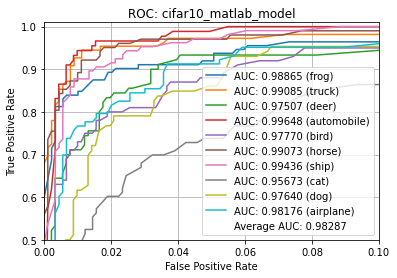

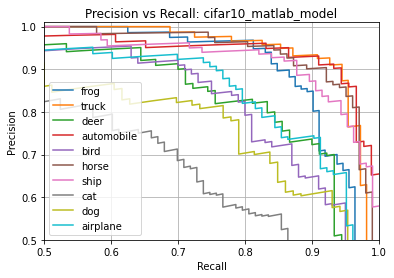

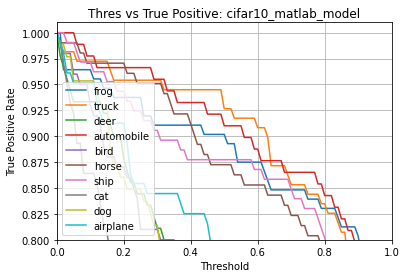

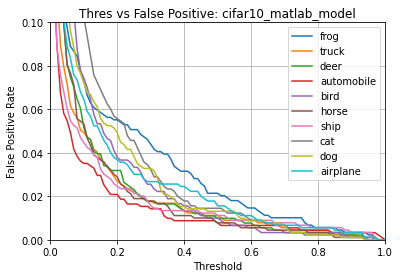

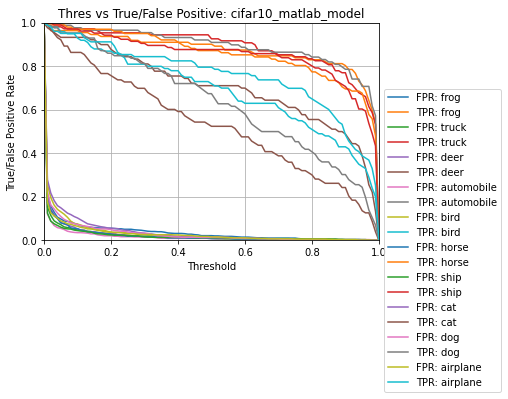

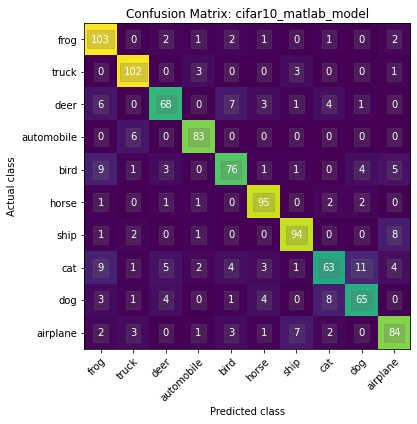

In [6]:
from mltk.core import ClassifierEvaluationResults

# Use the MLTK to evaluate the ONNX model predictions
results = ClassifierEvaluationResults(
    name=MODEL_NAME,
    classes = mapped_class_labels
)

print('Evaluating the ONNX model predictions ...')
results.calculate(y_test[:len(y_pred)], y_pred)
print(results.generate_summary())

results.generate_plots()

## Convert ONNX to Quantized TF-Lite Model File

Now that our Python environment is setup and we're able to get accurate results from our `.onnx` model, we are ready to convert it to a `.tflite` model file.

### Simplify the ONNX model

While optional, this step can help reduce the complexity of the ONNX 
by using the [ONNX Simplifier](https://github.com/daquexian/onnx-simplifier) Python package.

This can help reduce the execution overhead on the embedded device.

__NOTE:__ You can view the contents of the generated `.onnx` model file by dragging and dropping onto the webapge: [netron.app](https://netron.app/)

In [9]:
import onnxsim
import onnx

simplified_onnx_model, success = onnxsim.simplify(ONNX_MODEL_PATH)
assert success, 'Failed to simplify the ONNX model. You may have to skip this step'
simplified_onnx_model_path =  f'{WORKING_DIR}/{MODEL_NAME}.simplified.onnx'

print(f'Generating {simplified_onnx_model_path} ...')
onnx.save(simplified_onnx_model, simplified_onnx_model_path)
print('done')

Generating E:/reed/mltk/cifar10_matlab_model_onnx_to_tflite/cifar10_matlab_model.simplified.onnx ...
done


### Convert to OpenVino Intermediate Format

Recall that the ONNX format uses the `NCHW` format while TF-Lite uses the `NHWC` format to store the model tensors.  
While doable, converting from one format to the other is non-trivial. As such, additional steps are required to do the conversion.

The first step is converting the `.onnx` model to the [OpenVino](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html) intermediate format.  
This is done using the tools installed by the [openvino_dev](https://pypi.org/project/openvino-dev/) Python package.

In [11]:
import sys
import os

# Import the model optimizer tool from the openvino_dev package
from openvino.tools.mo import main as mo_main
import onnx
from onnx_tf.backend import prepare
from mltk.utils.shell_cmd import run_shell_cmd

# Load the ONNX model
onnx_model = onnx.load(ONNX_MODEL_PATH)
tf_rep = prepare(onnx_model)

# Get the input tensor shape
input_tensor = tf_rep.signatures[tf_rep.inputs[0]]
input_shape = input_tensor.shape
input_shape_str = '[' + ','.join([str(x) for x in input_shape]) + ']'


openvino_out_dir = f'{WORKING_DIR}/openvino'
os.makedirs(openvino_out_dir, exist_ok=True)


print(f'Generating openvino at: {openvino_out_dir}')
cmd = [
    sys.executable, mo_main.__file__,
    '--input_model', simplified_onnx_model_path,
    '--input_shape', input_shape_str,
    '--output_dir', openvino_out_dir,
    '--data_type', 'FP32'

]
retcode, retmsg = run_shell_cmd(cmd,  outfile=sys.stdout)
assert retcode == 0, 'Failed to do conversion'

Generating openvino at: E:/reed/mltk/cifar10_matlab_model_onnx_to_tflite/openvino
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	E:/reed/mltk/cifar10_matlab_model_onnx_to_tflite/cifar10_matlab_model.simplified.onnx
	- Path for generated IR: 	E:/reed/mltk/cifar10_matlab_model_onnx_to_tflite/openvino
	- IR output name: 	cifar10_matlab_model.simplified
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,3,32,32]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config fi

### Convert from OpenVino to TF-Lite-Float32 

Next, we use the [openvino2tensorflow](https://github.com/PINTO0309/openvino2tensorflow) Python package to convert from the OpenVino intermediate format to a `.tflite` model file.  
The generated model file has all of its weights and tensors in the __float32__ data type.

__NOTE:__ You can view the contents of the `.tflite` model file by dragging and dropping onto the webapge: [netron.app](https://netron.app/)

In [12]:
import os
from mltk.utils.shell_cmd import run_shell_cmd

openvino2tensorflow_out_dir = f'{WORKING_DIR}/openvino2tensorflow'
openvino_xml_name = os.path.basename(simplified_onnx_model_path)[:-len('.onnx')] + '.xml'


if os.name == 'nt':
  openvino2tensorflow_exe_cmd = [sys.executable, os.path.join(os.path.dirname(sys.executable), 'openvino2tensorflow')]
else:
  openvino2tensorflow_exe_cmd = ['openvino2tensorflow']

print(f'Generating openvino2tensorflow model at: {openvino2tensorflow_out_dir} ...')
cmd = openvino2tensorflow_exe_cmd + [
    '--model_path', f'{openvino_out_dir}/{openvino_xml_name}',
    '--model_output_path', openvino2tensorflow_out_dir,
    '--output_saved_model',
    '--output_no_quant_float32_tflite'
]

retcode, retmsg = run_shell_cmd(cmd)
assert retcode == 0, retmsg
print('done')

Generating openvino2tensorflow model at: E:/reed/mltk/cifar10_matlab_model_onnx_to_tflite/openvino2tensorflow ...
done


### Quantize the TF-Lite Model

The final conversion step is converting the `.tflite` model file which has __float32__ tensors into a `.tflite` model file that has __int8__ tensors.
A model with __int8__ tensors executes much more efficiently on an embedded device and also reduces the memory requirements by a factor of 4.

This conversion process is called [Post-Training Quantization](https://www.tensorflow.org/lite/performance/post_training_quantization).  
To do the conversion, we use the [TfliteConverter](https://www.tensorflow.org/lite/convert) that comes with Tensorflow.

To do the quantization, we need a _representative dataset_. We use the `x_test` samples for this purpose.

__NOTE:__ You can view the contents of the quantized `.tflite` model file by dragging and dropping onto the webapge: [netron.app](https://netron.app/)

In [13]:
import tensorflow as tf

tflite_int8_model_path = f'{WORKING_DIR}/{MODEL_NAME}.int8.tflite'

converter = tf.lite.TFLiteConverter.from_saved_model(openvino2tensorflow_out_dir)

def representative_dataset():
    for i, sample in enumerate(x_test):
        yield [np.expand_dims(sample, axis=0)]
        if i >= 1000: # We only need a small portion of the dataset to do the quantization
            break

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # We only want to use int8 kernels
converter.inference_input_type = tf.float32 # Can also be tf.int8
converter.inference_output_type = tf.float32  # Can also be tf.int8
converter.representative_dataset = representative_dataset

print(f'Generating {tflite_int8_model_path} ...')
tflite_quant_model = converter.convert()

with open(tflite_int8_model_path, 'wb') as f:
    f.write(tflite_quant_model)

print('done')

Generating E:/reed/mltk/cifar10_matlab_model_onnx_to_tflite/cifar10_matlab_model.int8.tflite ...
done


## Profile the Quantized Model

Now that we have converted the `.onnx` model to a quantized `.tflite` model, let's profile it to see if it can run on an embedded target.

For this, we use the [Model Profiler](https://siliconlabs.github.io/mltk/docs/guides/model_profiler.html) that comes with the MLTK.

In [14]:
from mltk.core import profile_model

results = profile_model(
    tflite_int8_model_path,
    accelerator='mvp' # Optional profile using the MVP hardware accelerator
)
print(results)

Profiling model in simulator ...
Using Tensorflow-Lite Micro version: b13b48c (2022-06-08)
Searching for optimal runtime memory size ...
Op2-CONV_2D not supported: Output vector stride (2048) exceeded (max=2047)
Op3-MAX_POOL_2D not supported: Hardware limits exceeded
Op2-CONV_2D not supported: Output vector stride (2048) exceeded (max=2047)
Op3-MAX_POOL_2D not supported: Hardware limits exceeded
Op2-CONV_2D not supported: Output vector stride (2048) exceeded (max=2047)
Op3-MAX_POOL_2D not supported: Hardware limits exceeded
Op2-CONV_2D not supported: Output vector stride (2048) exceeded (max=2047)
Op3-MAX_POOL_2D not supported: Hardware limits exceeded
Op2-CONV_2D not supported: Output vector stride (2048) exceeded (max=2047)
Op3-MAX_POOL_2D not supported: Hardware limits exceeded
Op2-CONV_2D not supported: Output vector stride (2048) exceeded (max=2047)
Op3-MAX_POOL_2D not supported: Hardware limits exceeded
Op2-CONV_2D not supported: Output vector stride (2048) exceeded (max=2047)
Op

## Evaluate the Quantized Model

Additionally, we can evaluate the quantized model to see how accurate it is:

In [15]:
from mltk.core import TfliteModel


tflite_model = TfliteModel.load_flatbuffer_file(tflite_int8_model_path)
print(tflite_model.summary())

n_samples = min(len(x_test), 100) # Only evaluate up to 100 samples
y_pred = np.empty((n_samples, n_classes), dtype=np.float32)

print(f'Executing {n_samples} samples in {tflite_int8_model_path}')
for i, x in enumerate(x_test[:n_samples]):
    pred = tflite_model.predict(x, y_dtype=np.float32)
    y_pred[i] = pred

print('done')

+-------+-------------+-------------------+-----------------+----------------------------------------------------+
| Index | OpCode      | Input(s)          | Output(s)       | Config                                             |
+-------+-------------+-------------------+-----------------+----------------------------------------------------+
| 0     | quantize    | 32x32x3 (float32) | 32x32x3 (int8)  | Type=none                                          |
| 1     | pad         | 32x32x3 (int8)    | 36x36x3 (int8)  | Type=padoptions                                    |
|       |             | 2 (int32)         |                 |                                                    |
| 2     | conv_2d     | 36x36x3 (int8)    | 32x32x64 (int8) | Padding:valid stride:1x1 activation:relu           |
|       |             | 5x5x3 (int8)      |                 |                                                    |
|       |             | 64 (int32)        |                 |                   

Evaluating the int8 .tflite model predictions ...
Name: cifar10_matlab_model
Model Type: classification
Overall accuracy: 85.000%
Class accuracies:
- frog = 100.000%
- truck = 100.000%
- ship = 100.000%
- horse = 90.909%
- airplane = 90.000%
- automobile = 83.333%
- bird = 75.000%
- deer = 71.429%
- cat = 60.000%
- dog = 50.000%
Average ROC AUC: 97.949%
Class ROC AUC:
- ship = 100.000%
- frog = 100.000%
- airplane = 99.889%
- automobile = 99.823%
- truck = 99.796%
- horse = 98.672%
- cat = 97.778%
- deer = 97.389%
- dog = 94.293%
- bird = 91.848%



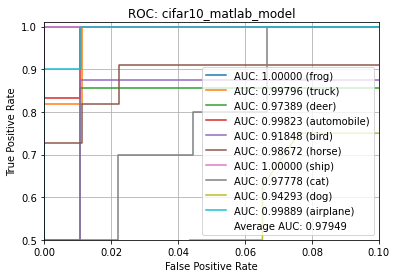

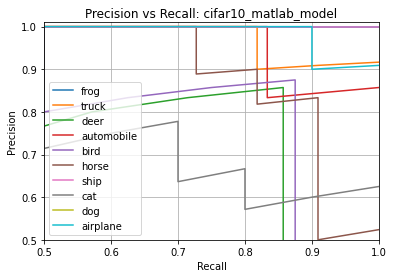

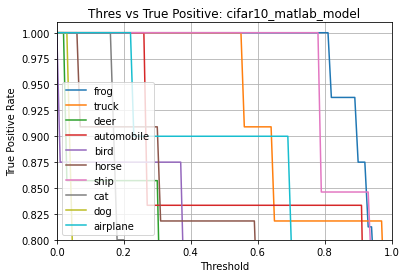

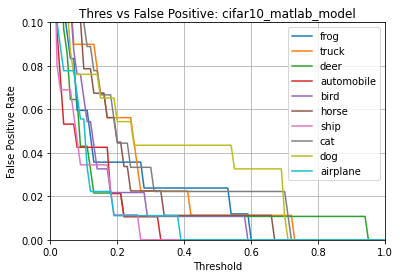

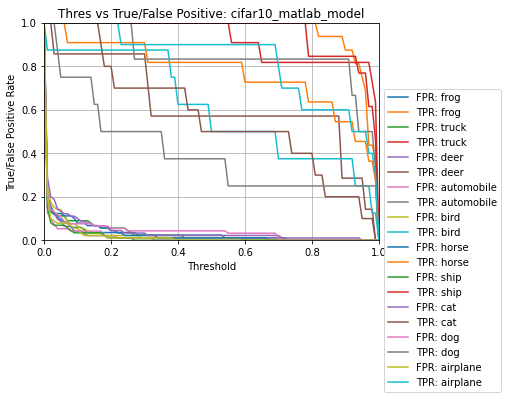

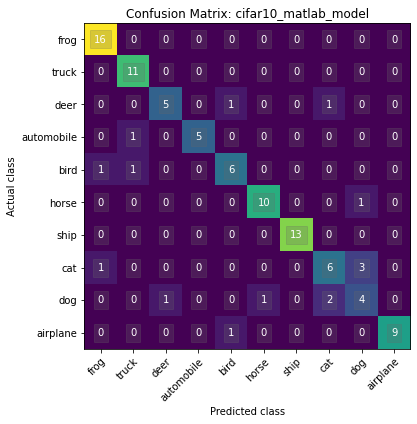

In [16]:
from mltk.core import ClassifierEvaluationResults

# Use the MLTK to evaluate the ONNX model predictions
results = ClassifierEvaluationResults(
    name=MODEL_NAME,
    classes = mapped_class_labels
)

print('Evaluating the int8 .tflite model predictions ...')
results.calculate(y_test[:len(y_pred)], y_pred)
print(results.generate_summary())

results.generate_plots()

## Next Steps

Now that we have an __int8__ `.tflite` model file, we can deploy it to our embedded target using the Gecko SDK.  

Refer to the following links for more details:
- [Gecko SDK Documentation](https://docs.silabs.com/gecko-platform/latest/machine-learning/tensorflow/getting-started)
- [MLTK C++ Development](https://siliconlabs.github.io/mltk/docs/cpp_development/index.html)